## Import Libraries

In [1]:
import numpy as np
import jax.numpy as jnp
import jax
from jax import grad, jvp,vmap,jacrev,jacfwd,jit
from jax._src.lax.lax import log
import matplotlib.pyplot as py
from jax import random
key = jax.random.PRNGKey(0)

#TF here is just to download mnist_data_set
import tensorflow as tf
tf.config.experimental.set_visible_devices([], "GPU")

## Load MNIST dataset

In [2]:
#load data
(mnist_train_data,mnist_train_labels),(mnist_test_data,mnist_test_labels)=tf.keras.datasets.mnist.load_data()
mnist_train_data=mnist_train_data.reshape(60000,784).astype('float32')
mnist_test_data=mnist_test_data.reshape(10000,784).astype('float32')
mnist_train_data=mnist_train_data/255.0
mnist_test_data=mnist_test_data/255.0

11501568/11490434 [==============================] - 0s 0us/step


## Functions: 


In [3]:
'''
Functions:

forward (weight1,weight2,inputs,target) 
  Description: 
    Standard MLP with -log loss output for multi-classification. For this code this is literally hardcoded to a 2 layer perceptron. This can be definiately changed!
  Parameters:
    weight1,weight2: np.array
      weights of layer1 and layer2 respectively. Weights are separated as two parameters for clarity. 
    inputs: np.array 
      input for MLP.
    target: np.array
      The real label for the image. 
  Returns: 
    -log loss


predict (weight1,weight2,inputs)
  Description: 
    Similar to forward, but output is softmax vector.
  Parameters:
    Similar to forward without target
  Returns: 
    Softmax vector


calc_jvp (weights1,weights2,tagents1,tangents2,input,target)
  Description: 
    Calculates the jacobian-vector product of the MLP. JVP function is from jax. 
    Due to the way JVPs are calculated, the JVP for each layer of the MLP must be calculated separately.

  Parameters: 
    weights1,weights2: np.arary 
      weights of layer1 and layer2 respectively. 
    tangents1,tagents2:np.array
      tangent vectors of layer1 and layer2 respectively. These must be the same shape as weight vectors. 
    input:np.array
      input similar to forward function
    target:np.array
      target similar to forward function
    
    Returns: 
    A list with 2 elements representing the JVP of the first and second layer. Importantly, the elemnts are scalar values. Keep this in mind


fast_gradient (weights1,weights2,key,input,target)
  Description: 
    Contrary to the function's name, this is not very fast. 
    Function generates a matrix the same shape as a given layer from a normal distribution. There are two tangent vectors generated, for layer1 and layer2. 
    The tangents are used to calculate JVP for the MLP. Remember this will be two scalar values in a list.

    After taking JVP of a given layer of the MLP, the same tangent used to generate the JVP is multiplied with the product. 
    Since the tangent vector used is the same shape as the weight vector, the result is a matrix of the same shape as the weights of that layer. 
    This is taken as the 'gradient' for that layer. 

  Parameters:
    weights1,weights2: np.arary 
      weights of layer1 and layer2 respectively. 
    key: jax.random.PRNGKey(0) 
      Key, it is a jax thing requiring a key to randomly generate numbers. 
    input:np.array
      input similar to forward function
    target:np.array
      target similar to forward function

'''
def forward(weight1,weight2,inputs,target): 
  layer1= jnp.dot(weight1.T,inputs)
  layer1=jax.nn.sigmoid(layer1)
  layer2=jnp.dot(weight2.T,layer1) 
  layer2=jax.nn.softmax(layer2) 
  loss=-jnp.log(layer2[target])
 
  return loss

def predict(weight1,weight2,inputs): 
  layer1= jnp.dot(weight1.T,inputs)
  layer1=jax.nn.sigmoid(layer1)
  layer2=jnp.dot(weight2.T,layer1) 
  layer2=jax.nn.softmax(layer2) 
  return layer2

v_predict=vmap(predict,in_axes=(None,None,0)) #This is just a vectorization of predict, to allow batches of images to be classified. 


def calc_jvp(weights1,weights2,tangents1,tangents2,input,target):
  jac_accumulate=[]
  #layer1:
  f=lambda w1:forward(w1,weights2,input,target)
  _,jac=jvp(f,(weights1,),(tangents1,))
  jac_accumulate.append(jac)

  #layer2:
  f2=lambda w2:forward(weights1,w2,input,target)
  _,jac=jvp(f2,(weights2,),(tangents2,))
  jac_accumulate.append(jac)
  return jac_accumulate

np.random.seed(1001)
def fast_gradient(weights1,weights2,key,input,target):
  tan1=random.normal(key,(784,30))
  tan2=random.normal(key,(30,10))
  jac=calc_jvp(weights1,weights2,tan1,tan2,input,target)
  gradient=[]
  gradient.append(jac[0]*tan1) 
  gradient.append(jac[1]*tan2)
  return gradient

#vectorization of the fast_gradient function.
fast_gradient_=vmap(fast_gradient,in_axes=(None,None,None,0,0))

### Initialize weights

In [8]:

np.random.seed(1001)
#initialize weights: 
weight1=np.random.randn(784,30)
weight2=np.random.randn(30,10)


In [12]:
lr=0.1
loss=[]
tanctr=0

b=1
batch_size=1000


for epochs in range(20):
  
  for i in range(100):
    key, subkey = jax.random.split(key)   
    dw=jit((fast_gradient_))(weight1,weight2,subkey,mnist_train_data[b:b+batch_size],mnist_train_labels[b:b+batch_size])
        
    weight1-=lr*jnp.mean(dw[0],axis=0)
    weight2-=lr*jnp.mean(dw[1],axis=0) 
 
    
    b+=batch_size
    if b>50000:
      b=0

  #If you want to track loss
  #loss_=forward(weight1,weight2,mnist_train_data[0],mnist_train_labels[0])
  #loss.append(loss_)
  outputs=jnp.argmax(v_predict(weight1,weight2,mnist_test_data[0:100]),axis=1)
  print("Accuracy: " , len(jnp.where(outputs==mnist_test_labels[0:100])[0])/100)


Accuracy:  0.67
Accuracy:  0.69
Accuracy:  0.67
Accuracy:  0.74
Accuracy:  0.72
Accuracy:  0.71
Accuracy:  0.71
Accuracy:  0.7
Accuracy:  0.72
Accuracy:  0.72
Accuracy:  0.71
Accuracy:  0.74
Accuracy:  0.74
Accuracy:  0.74
Accuracy:  0.72
Accuracy:  0.76
Accuracy:  0.75
Accuracy:  0.74
Accuracy:  0.78
Accuracy:  0.76


In [14]:
#test
outputs=jnp.argmax(v_predict(weight1,weight2,mnist_test_data),axis=1)
print('Test Accuracy: ', len(jnp.where(outputs==mnist_test_labels)[0])/100 , '%' )

Test Accuracy:  78.92 %


Predicted:  0


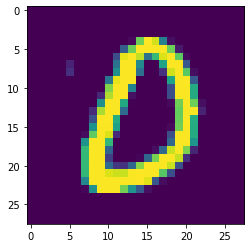

In [11]:
#view and test
im=7646
py.imshow(mnist_test_data[im].reshape(28,28))
val=jnp.argmax(predict(weight1,weight2,mnist_test_data[im]))
print('Predicted: ' , val)
